In [89]:
### import statements 
import obonet
from itertools import combinations 
from Bio import Medline
import networkx as nx
import string
from textblob import TextBlob  

import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import tree

In [22]:
# experiment configurations
MAX_NUMBER_BIGRAMS = 30
MAX_NUMBER_PUBLICATION = 1200

In [23]:
# parsing a medline file 
def parse_medline_rmap(medline_file):    
    map_abstracts = {}    
    pmid = ''
    abstract = ''  
    with open(medline_file) as medline_handle:
        records = Medline.parse(medline_handle)
        for record in records:         
            keys = record.keys()            
            if 'PMID' in keys and 'AB' in keys: 

                pmid = record['PMID']
                abstract = record['AB']
                
                map_abstracts[pmid] = abstract.lower()
    return map_abstracts  

In [24]:
def parse_chatGPT(chatGPTabstracts):
    count = 0
    map_abs = {}  
    read_handle = open(chatGPTabstracts)
    lines = read_handle.readlines()
    for line in lines:
        if len(line) > 1 and line.startswith('Abstract'):
            map_abs[count] = line
            count += 1
            # print(line[:100])
    return map_abs

In [25]:
def remove_string_special_characters(s):
      
    # removes special characters with ' '
    stripped = re.sub('[^a-zA-z\s]', '', s)
    stripped = re.sub('_', '', stripped)
      
    # Change any white space to one space
    stripped = re.sub('\s+', ' ', stripped)
      
    # Remove start and end white spaces
    stripped = stripped.strip()
    if stripped != '':
            return stripped.lower()

In [26]:
pubmed_abstracts = parse_medline_rmap('pubmed-alzheimers-set.txt')
cgpt_abstracts = parse_chatGPT('chaptGPTpubs.txt')

# cleaning PubMed articles from special characters
clean_pubmed_training = []
for abst in list(pubmed_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_pubmed_training.append(cleaned)
    
# cleaning chatGPT articles from special characters
clean_chatGPT = []
for abst in list(cgpt_abstracts.values())[0:]:
    cleaned = remove_string_special_characters(abst)    
    clean_chatGPT.append(cleaned)    
    

In [27]:
stop_words = set(stopwords.words('english'))
special_list = ['abstract']

def stopwords_rem_pubmed(clean_pubmed_training):
    stopped_pubmed_training = []
    for abst in clean_pubmed_training[:MAX_NUMBER_PUBLICATION]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if token not in stop_words:
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_pubmed_training.append(valid_rec)
    return stopped_pubmed_training
    
    
def stopwords_rem_chatGPT_dataset(clean_chatGPT):    
    stopped_chatGPT_training = []
    for abst in clean_chatGPT_training[:MAX_NUMBER_PUBLICATION]:
        valid_l = []
        valid_rec = []
        blob_object = TextBlob(abst)
        list_tokens = blob_object.words

        for token in list_tokens:        
            if (token not in stop_words) and (token not in special_list):
                valid_l.append(token)            
        valid_rec = ' '.join(valid_l)
        stopped_chatGPT_training.append(valid_rec)   
    return stopped_chatGPT_training


def stopwords_rem_chatGPT_article(clean_chatGPT_article):    
    stopped_chatGPT_training = []
    # for abst in clean_chatGPT_training[:MAX_NUMBER_PUBLICATION]:
    valid_l = []
    valid_rec = []
    blob_object = TextBlob(clean_chatGPT_article)
    list_tokens = blob_object.words

    for token in list_tokens:        
        if (token not in stop_words) and (token not in special_list):
            valid_l.append(token)            
    valid_rec = ' '.join(valid_l)
    stopped_chatGPT_training.append(valid_rec)   
    return stopped_chatGPT_training

In [53]:
stopped_pubmed_training = stopwords_rem_pubmed(clean_pubmed_training)

stopped_chatGPT_test = []
for article in clean_chatGPT:

    stopped_chatGPT_test.append(stopwords_rem_chatGPT_article(article))




In [54]:
# for art in stopped_pubmed_training[100:200]:
#     print(art)
#     print('------')

# print('=========')    
# for art in stopped_chatGPT_test[:3]:
#     print(art)
#     print('------')    


In [55]:
# Getting PubMed bigrams
def compute_pubmed_bigrams(stopped_pubmed_training):
    list_bigrams = []

    vectorizer = CountVectorizer(ngram_range =(2, 2))
    X1 = vectorizer.fit_transform(stopped_pubmed_training)
    features = (vectorizer.get_feature_names_out())
    # print("\n\nX1 : \n", X1.toarray())

    # Applying TFIDF
    # You can still get n-grams here
    vectorizer = TfidfVectorizer(ngram_range = (2, 2))
    X2 = vectorizer.fit_transform(stopped_pubmed_training)
    scores = (X2.toarray())
    # print("\n\nScores : \n", scores)

    # Getting top ranking features
    sums = X2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
    words = (ranking.sort_values('rank', ascending = False))

    bigram_ranks = {}
    for index, row in words.iterrows():
        # print(row['term'],'\t\t\t',  row['rank'])

        splits = row['term'].split()
        bigram_ranks[row['rank']] = (splits[0], splits[1])

    count = 0    
    for k, v in bigram_ranks.items():
        if count < MAX_NUMBER_BIGRAMS:
            # print(k,'\t',  v)
            count += 1
        list_bigrams.append(v)
    return bigram_ranks

In [56]:
# Getting chatGPT bigrams
def compute_chatGPT_bigrams(stopped_chatGPT_test):
    list_bigrams = []

    vectorizer = CountVectorizer(ngram_range =(2, 2))
    X1 = vectorizer.fit_transform(stopped_chatGPT_test)
    features = (vectorizer.get_feature_names_out())

    # Applying TFIDF
    # You can still get n-grams here
    vectorizer = TfidfVectorizer(ngram_range = (2, 2))
    X2 = vectorizer.fit_transform(stopped_chatGPT_test)
    scores = (X2.toarray())
    # print("\n\nScores : \n", scores)

    # Getting top ranking features
    sums = X2.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append( (term, sums[0, col] ))
    ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
    words = (ranking.sort_values('rank', ascending = False))

    bigram_ranks = {}
    for index, row in words.iterrows():
        splits = row['term'].split()
        bigram_ranks[row['rank']] = (splits[0], splits[1])

    count = 0    
    for k, v in bigram_ranks.items():
        if count < MAX_NUMBER_BIGRAMS:
            count += 1
        list_bigrams.append(v)
    return bigram_ranks 

In [57]:
pubmed_bigrams_map_training = compute_pubmed_bigrams(stopped_pubmed_training[:100])
# print(len(pubmed_bigrams_map_training))

training_list = pubmed_bigrams_map_training.values()


# ----------   Constructing  Training  Model ----------# 

graph_training_model = nx.Graph()
graph_training_model.add_edges_from(training_list)

node_count = len(graph_training_model.nodes())
edge_count = len(graph_training_model.edges())
print('Original node count: ', node_count)
print('Original edge count: ', edge_count)

giant = max(nx.connected_components(graph_training_model), key=len)
CC = len(giant)
print("Training size the giant component:", CC)

Original node count:  702
Original edge count:  887
ChatGPT size the giant component: 513


In [73]:
def reconstruct_giant(giant_list, training_graph):
    G = nx.Graph()
    for edge in training_graph.edges():
        
        for index in range(0, len(giant_list)):
            for index2 in range(1, len(giant_list)):
                if training_graph.has_edge(giant_list[index], giant_list[index2]):
                    G.add_edge(giant_list[index], giant_list[index2])
    return G

In [74]:
giant_cc = reconstruct_giant(list(giant), graph_training_model)
print(giant_cc)

Graph with 513 nodes and 782 edges


In [103]:
# calibrating step   ....

# STEP1: -- compute dataset bigrams -------

pubmed_bigrams_map_tst1 = compute_pubmed_bigrams(stopped_pubmed_training[100:200])
print(len(pubmed_bigrams_map_tst1))
calb1_edges = list(pubmed_bigrams_map_tst1.values())

966


In [61]:
print('Before Computing: ', giant_cc)

Before Computing:  Graph with 513 nodes and 782 edges


In [100]:
 # STEP2: -- compute individual articles bigrams -------
    
def calibrate_using_pubmed_sets(ds_label, begin_index, end_index, training_graph):

    no_added_edges_per_article = []
    for abst in stopped_pubmed_training[begin_index:end_index]:

        tokens = nltk.word_tokenize(abst)

        # compute the bigrams
        bigrams = list(nltk.bigrams(tokens))

        # -------  check if the giant has the bigram components, add new edge 
        # -------          otherwise, don't add new edges
        # -------  count how many nodes    
        
        count = 0
        added_edges = []
        for bigram in bigrams:

            if training_graph.has_node(bigram[0]) and training_graph.has_node(bigram[1]):

                if not training_graph.has_edge(bigram[0], bigram[1]):

                    training_graph.add_edge(bigram[0], bigram[1])
                    count += 1
                    added_edges.append((bigram[0], bigram[1]))
                    
        no_added_edges_per_article.append(count)            
        giant_cc.remove_edges_from(added_edges)
    return no_added_edges_per_article

In [124]:
 # STEP2: -- compute individual articles bigrams -------
    
def compute_chatGPT_bigrams(stopped_articles, training_graph):

    no_added_edges_per_chatGPT_article = []
    for abst in stopped_articles:

        tokens = nltk.word_tokenize(abst[0])

        # compute the bigrams
        bigrams = list(nltk.bigrams(tokens))

        # -------  check if the giant has the bigram components, add new edge 
        # -------          otherwise, don't add new edges
        # -------  count how many nodes    
        
        count = 0
        added_edges = []
        for bigram in bigrams:

            if training_graph.has_node(bigram[0]) and training_graph.has_node(bigram[1]):

                if not training_graph.has_edge(bigram[0], bigram[1]):

                    training_graph.add_edge(bigram[0], bigram[1])
                    count += 1
                    added_edges.append((bigram[0], bigram[1]))
                    
        no_added_edges_per_chatGPT_article.append(count)            
        giant_cc.remove_edges_from(added_edges)
    return no_added_edges_per_chatGPT_article

In [125]:
scores = compute_chatGPT_bigrams(stopped_chatGPT_test, giant_cc)

In [127]:
# scores

In [111]:
# scores = compute_bigrams_per_chatGPT_article('ChatGPT', stopped_chatGPT_test, giant_cc)

In [128]:
def calc_mean(tst_set_list):

    # compute the average (with check for empty list)
    if len(tst_set_list) == 0:
        average = 0
    else:
        average = sum(tst_set_list) / len(tst_set_list)

    # print the average
    print("The average of the list is:", average)
    return average

In [129]:
calb_folds_results = {}
count = 0
for index in range(100,1001):
    label_prefix = 'TST'
    if index % 100 == 0:
        count += 1
        tst_list = calibrate_using_pubmed_sets(label_prefix + str(count), index, index+100, giant_cc)
        # print(tst_list)
        tst_mean = calc_mean(tst_list)
        calb_folds_results[label_prefix + str(count)] = sorted(tst_list) #, reverse=True
        

The average of the list is: 24.84
The average of the list is: 24.99
The average of the list is: 21.5
The average of the list is: 23.63
The average of the list is: 22.36
The average of the list is: 22.76
The average of the list is: 23.4
The average of the list is: 22.5
The average of the list is: 23.59
The average of the list is: 21.87


In [130]:
calb_folds_results['ChatGPT'] = sorted(list(scores)) # , reverse=True

len(calb_folds_results)

11

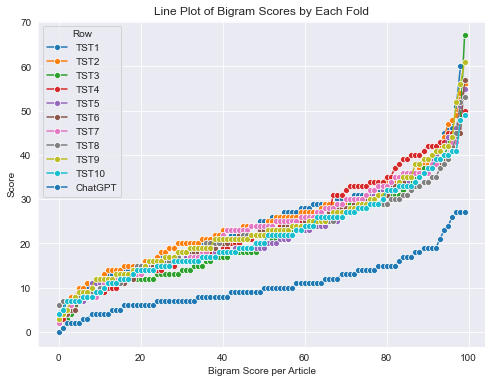

In [137]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(calb_folds_results)

df_transposed = df.transpose()


plt.figure(figsize=(8, 6))



# Set the style of the plot
sns.set_style("darkgrid")

# Loop through each row of the DataFrame
for index, row in df_transposed.iterrows():
    # Create a line plot for the current row
    sns.lineplot(data=row, marker='o', label=index)
    
# Set the title and axis labels
plt.title('Line Plot of Bigram Scores by Each Fold')
plt.xlabel('Bigram Score per Article')
plt.ylabel('Score')

# Show the legend and plot
plt.legend(title='Row', loc='best')

plt.savefig('chatGPT_bigram_scores_1000.png', dpi=1000)

plt.show()

In [132]:
def measure_chat_GPT_article(article_text, training_graph):
    # chat_no_added_edges = []
    # for abst in stopped_pubmed_training[begin_index:end_index]:

    tokens = nltk.word_tokenize(article_text)

    # compute the bigrams
    bigrams = list(nltk.bigrams(tokens))

    # -------  check if the giant has the bigram components, add new edge 
    # -------          otherwise, don't add new edges
    # -------  count how many nodes    

    count = 0
    added_edges = []
    for bigram in bigrams:

        if training_graph.has_node(bigram[0]) and training_graph.has_node(bigram[1]):

            if not training_graph.has_edge(bigram[0], bigram[1]):

                training_graph.add_edge(bigram[0], bigram[1])
                count += 1
                added_edges.append((bigram[0], bigram[1]))

        giant_cc.remove_edges_from(added_edges)
        
    return added_edges    

In [139]:
## classify ChatGPT articles one at a time

scores = []
lower_bound = 21.96
upper_bound = 24.93

counter = 0
positive = 0
negative = 0

for fake_article in stopped_chatGPT_test[0:100]:
    edges_added = measure_chat_GPT_article(fake_article[0], giant_cc) 
    counter += 1
    if (len(edges_added) >= lower_bound) and  (len(edges_added) <= upper_bound):
        positive += 1
        print('Article: ', counter, ', added edges: ', len(edges_added), 'POSITIVE')
    else:
        negative += 1
        print('Article: ', counter, ', added edges: ', len(edges_added), 'NEGATIVE')   
        
    scores.append(len(edges_added))

print('\n\n-------------------------------------\n')    
print('NeoNet Classifier TRUE POSITIVE :  ', format(positive/100, '.2f'))
print('NeoNet Classifier FALSE NEGATIVE:  ', format(negative/100, '.2f'))
print('\n\n-------------------------------------\n')      


Article:  1 , added edges:  0 NEGATIVE
Article:  2 , added edges:  4 NEGATIVE
Article:  3 , added edges:  2 NEGATIVE
Article:  4 , added edges:  4 NEGATIVE
Article:  5 , added edges:  2 NEGATIVE
Article:  6 , added edges:  4 NEGATIVE
Article:  7 , added edges:  7 NEGATIVE
Article:  8 , added edges:  10 NEGATIVE
Article:  9 , added edges:  13 NEGATIVE
Article:  10 , added edges:  10 NEGATIVE
Article:  11 , added edges:  10 NEGATIVE
Article:  12 , added edges:  4 NEGATIVE
Article:  13 , added edges:  4 NEGATIVE
Article:  14 , added edges:  14 NEGATIVE
Article:  15 , added edges:  11 NEGATIVE
Article:  16 , added edges:  15 NEGATIVE
Article:  17 , added edges:  11 NEGATIVE
Article:  18 , added edges:  15 NEGATIVE
Article:  19 , added edges:  10 NEGATIVE
Article:  20 , added edges:  10 NEGATIVE
Article:  21 , added edges:  7 NEGATIVE
Article:  22 , added edges:  5 NEGATIVE
Article:  23 , added edges:  11 NEGATIVE
Article:  24 , added edges:  11 NEGATIVE
Article:  25 , added edges:  14 NEGA

In [225]:

# # Add a new row to the transposed DataFrame
# df_article_bigrams.loc['ChatGPT'] = scores


516